## Implementación del algoritmo de Kittler


In [1]:
import torch

In [2]:
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
U_1 = torch.tensor(
    np.array(Image.open('input/C4_02_1_1_DAPI_001.bmp').convert('L')))

output_path = "salida.png"
#example for writing image
Y = torch.zeros(U_1.shape)
print(Y)
Y_pil = Image.fromarray(Y.numpy().astype(np.uint8))
Y_pil.save(output_path)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


### Calculo de Momentos Estadisticos

Implemente una funcion `calcular_momentos_estadisticos(T,p)` la cual reciba un umbral candidato *T* y una funcion de densidad *p*, y retorne todos los parametros de la función. Comente su implementacion con detalle en este informe

### Calcular Costo

Implemente la función calcular_costo_J(T) la cual calcule el costo del umbral candidato T. Comente su implementacion con detalle en este informe.

### Calculo T Optimo

Basado en ambas funciones, implemente la función calcular_T_optimo_Kittler(Imagen) la cual retorne el T optimo para umbralizar la imagen recibida, además de la imagen umbralizada.

### Aplicación del Algoritmo de Kittler

Aplique el algoritmo de Kittler en la imagen cuadro1_005.bmp, pro-
vista

#### Graficación del histograma
Grafique el histograma normalizado de la imagen de entrada
provista

In [4]:
data_tensor = torch.tensor(
    np.array(Image.open('input/cuadro1_005.bmp').convert('L')))

print(data_tensor)

tensor([[219, 218, 219,  ..., 221, 216, 217],
        [220, 221, 220,  ..., 222, 220, 225],
        [216, 214, 220,  ..., 222, 220, 220],
        ...,
        [218, 219, 220,  ..., 221, 221, 217],
        [226, 219, 219,  ..., 219, 224, 221],
        [217, 223, 220,  ..., 221, 225, 224]], dtype=torch.uint8)


In [10]:
data_tensor.shape

torch.Size([455, 756])

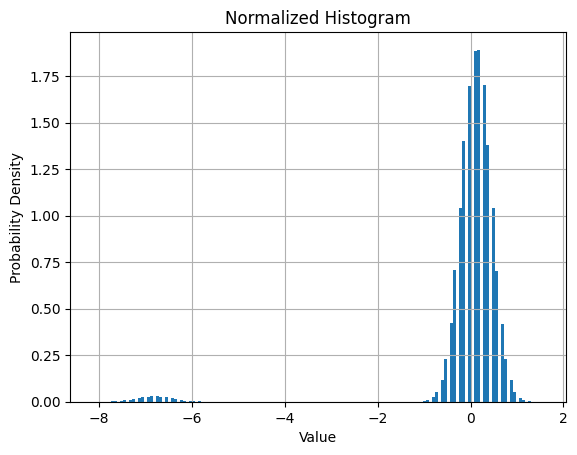

In [24]:
data_tensor = data_tensor.float()
mean = torch.mean(data_tensor)
std = torch.std(data_tensor)

normalized_data = (data_tensor - mean) / std
flattened_data = normalized_data.view(-1)
data_np = flattened_data.numpy()

plt.hist(data_np, bins=150, density=True, stacked=True, alpha=1)
plt.xlabel('Value')


plt.ylabel('Probability Density')
plt.title('Normalized Histogram')
plt.grid(True)
plt.show()

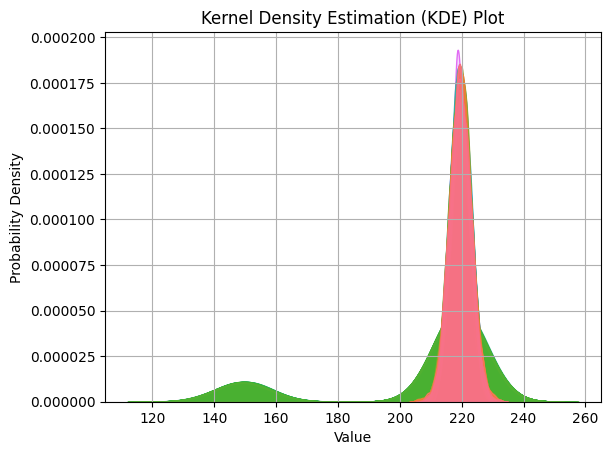

In [14]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a PyTorch tensor called 'data_tensor'
data_np = data_tensor.numpy()

# Create a KDE plot
sns.kdeplot(data_np, fill=True, legend=False)
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Kernel Density Estimation (KDE) Plot')
plt.grid(True)
plt.show()

### Distancia de Bhattacharyaa

Implemente la funcion´ calcular bhattacharyya distance(p,q), para comparar las funciones de densidad estimada con el ajuste del modelo mixto Gaussiano con Kittler p (x) y la aproximacion de la densidad
con el histograma de los datos q (x) para las dos pruebas realizadas
con la imagen y el audio.


In [7]:
#Estamos asumiendo que p y q son los valores de probabilidad, se puede depurar para que solo vengan las funciones y se calcula


def bhattacharyya_distance(p, q):
    device = p.device

    sqrt_product = torch.sqrt(p * q)
    sum_sqrt_product = torch.sum(sqrt_product)
    distance = -torch.log(sum_sqrt_product)

    return distance.item()

# Example usage:
p = torch.tensor([0.2, 0.3, 0.5])
q = torch.tensor([0.2, 0.3, 0.5])

distance = bhattacharyya_distance(p, q)
print("Bhattacharyya distance:", distance)

Bhattacharyya distance: -0.0
